In [75]:
# CODE FOR A CONVOLUTIONAL NEURAL NETWORK TO CLASSIFY SKIN LESIONS

# loading a reload extension, to make sure all python modules in other files are checked every time the code runs
%load_ext autoreload

# executing said extension, mode 2 used to reload all modules every time unless specifically ignored using '%aimport'
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# importing all relevant libraries for performing tasks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
# this ensures that all repeaeted 'random' variables are the same, enabling repeated experimentation
np.random.seed(42)

# importing specific functions from libraries
from sklearn.model_selection import train_test_split # needed to split into test and training sets
from scipy import stats # as the name suggests, stats functions
from sklearn.preprocessing import LabelEncoder # converts text labels to numeric ones for data processing

In [77]:
# imports PyTorch libraries, which I use as the ML deep learning model
import torch 

In [78]:
# time to load the HAM10000 dataset CSV into a DataFrame called 'skin_df' for short
# using the pandas library
skin_df = pd.read_csv('./data/HAM10000_metadata.csv') #file path on my computer

In [79]:
# lets take a look at the metadata to make sure it makes sense, there should be around 10k rows of 8 columns
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [80]:
# to check again but as a DataFrama Dimension Structure output
skin_df.shape

(10015, 8)

In [81]:
# to understand how the data is assorted, we can break it down into types, as the metadata for skin lesion type
# is in the dx column, we ask the code to count the recurrence of each classification down this entire column
skin_df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  


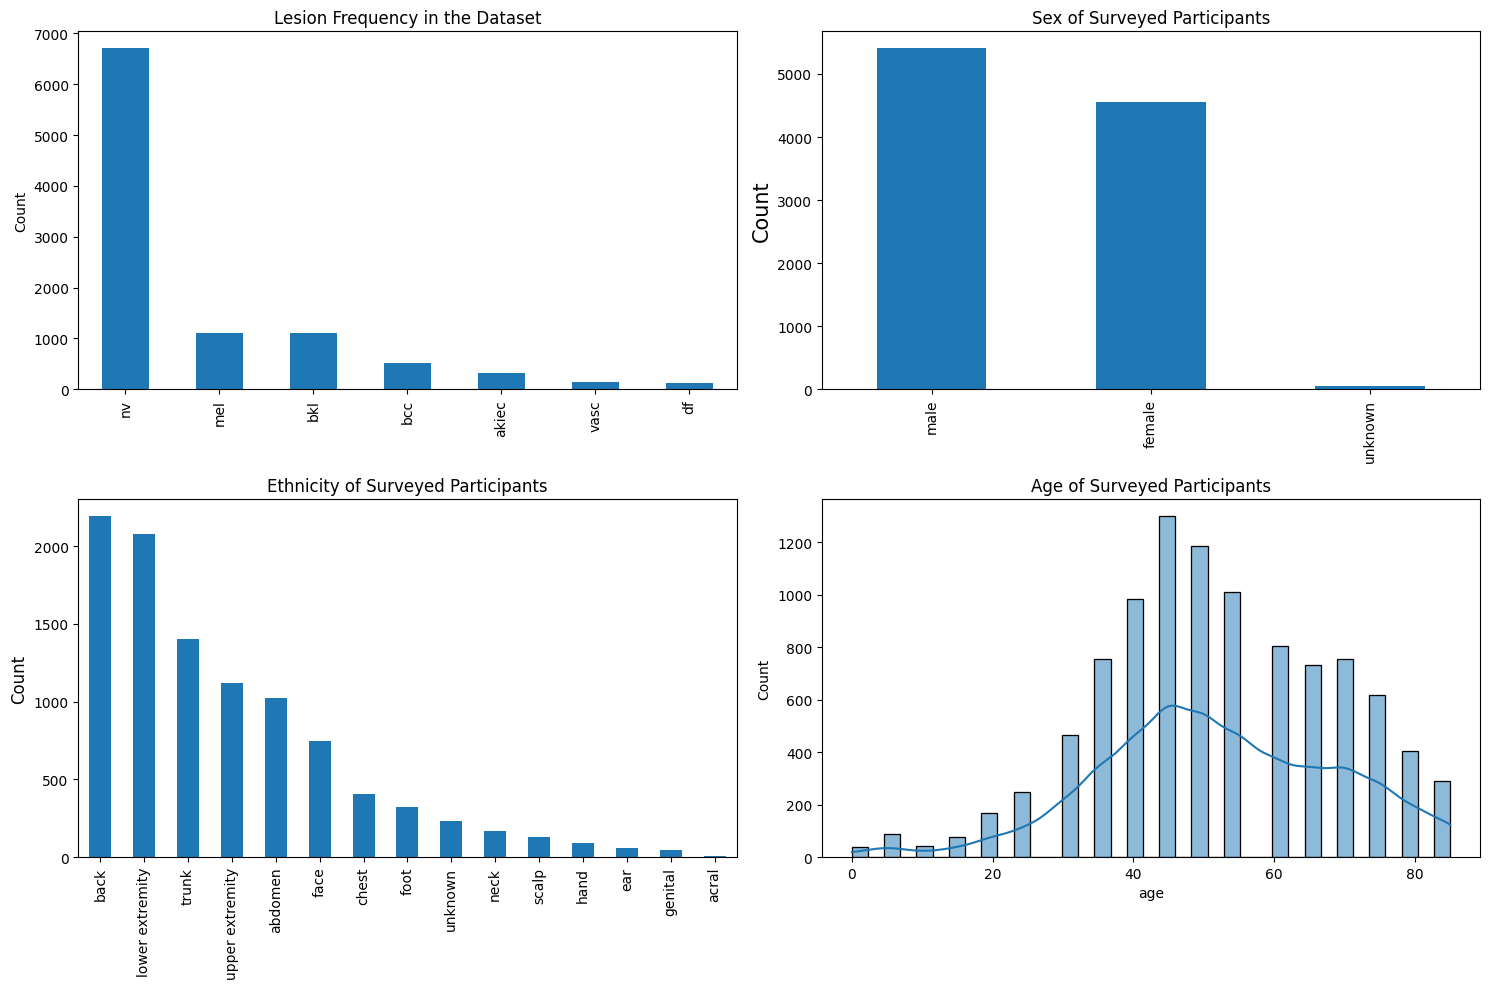

In [82]:
# this block formats the images that I add in later in the code
# setting the image resizing to 100x100 pixels, this is done to standardise and reduce computational load and can be adjusted accordingly
SIZE=100

# label encoding to numeric values from text - this takes all text labels and translates them into numeric form 
# to enable processessing
le = LabelEncoder() # create an object le using the LabelEncoder tool that can be imposed in the next line
le.fit(skin_df['dx']) # imposes and trains the label encoder onto the main column of interest, being the classification column
LabelEncoder()
print(list(le.classes_)) # prints the list of unique labels that have been encoded, providing insight into the different types of diagnoses in the dataset
 
skin_df['label'] = le.transform(skin_df["dx"]) # creates a new column for all these new numeric values
print(skin_df.sample(4)) # prints four random rows for inspection


# Data distribution visualization
fig = plt.figure(figsize=(15,10)) # initialises a new figure for plotting

#four subplots are created below, see titles for explanations

ax1 = fig.add_subplot(221) #creates the first subplot
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1) # assignes the relevant column of data
ax1.set_ylabel('Count') # sets the y axis label, x labels are automatic as it's a bar chart
ax1.set_title('Lesion Frequency in the Dataset'); # sets title to clear and descriptive message

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2, color='#1f77b4')
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex of Surveyed Participants');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Ethnicity of Surveyed Participants')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])] # removing null vlaues as we are dealing with ages and zeros will skew data
sns.histplot(sample_age['age'], kde=True); # plotting a histogram this time and a kernel density enstimate - KDE
ax4.set_title('Age of Surveyed Participants')

plt.tight_layout() # adjusts the subplots into the figure area
plt.show() # displays the four plots


In [83]:
# to check that the encoder worked, and what number is assigned to which label, we print 0-6 inclusive in a row - this will be useful when looking at labels
le.inverse_transform(range(7)) #despite range =7, we know it goes 0-6

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [84]:
# to confirm again, let us take a look at the metadata, and see if the labels match the above line of code
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0


In [85]:
# Distribution of data into various classes 
# We know from above that there is a large amount of some skin lesions but not others
#the aim of this block is to fix this to avoid bias
from sklearn.utils import resample
print(skin_df['label'].value_counts())


# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

min_samples = min([df_0.shape[0], df_1.shape[0], df_2.shape[0], df_3.shape[0], df_4.shape[0], df_5.shape[0], df_6.shape[0]])

n_samples=3000 
min_samples = n_samples
df_0_balanced = resample(df_0, replace=True, n_samples=min_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=min_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=min_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=min_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=min_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=min_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=min_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())



5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
Name: label, dtype: int64


In [86]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,rosendahl,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,rosendahl,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,rosendahl,0
...,...,...,...,...,...,...,...,...,...
2443,HAM_0005245,ISIC_0024375,vasc,consensus,70.0,female,abdomen,vidir_molemax,6
2323,HAM_0001920,ISIC_0031901,vasc,histo,55.0,male,back,vidir_modern,6
2409,HAM_0002390,ISIC_0029439,vasc,consensus,50.0,male,abdomen,vidir_molemax,6
2423,HAM_0002650,ISIC_0029742,vasc,consensus,5.0,male,back,vidir_molemax,6


In [87]:
# Creating a new directory to map metadata in csv to the relevant images, i.e. filename to fullpath
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob('data/HAM10000_images_*/*.jpg')}


In [88]:
# Take a look to see if it has worked, it should print out a bunch of fullpaths
image_path

{'ISIC_0024306': 'data\\HAM10000_images_part_1\\ISIC_0024306.jpg',
 'ISIC_0024307': 'data\\HAM10000_images_part_1\\ISIC_0024307.jpg',
 'ISIC_0024308': 'data\\HAM10000_images_part_1\\ISIC_0024308.jpg',
 'ISIC_0024309': 'data\\HAM10000_images_part_1\\ISIC_0024309.jpg',
 'ISIC_0024310': 'data\\HAM10000_images_part_1\\ISIC_0024310.jpg',
 'ISIC_0024311': 'data\\HAM10000_images_part_1\\ISIC_0024311.jpg',
 'ISIC_0024312': 'data\\HAM10000_images_part_1\\ISIC_0024312.jpg',
 'ISIC_0024313': 'data\\HAM10000_images_part_1\\ISIC_0024313.jpg',
 'ISIC_0024314': 'data\\HAM10000_images_part_1\\ISIC_0024314.jpg',
 'ISIC_0024315': 'data\\HAM10000_images_part_1\\ISIC_0024315.jpg',
 'ISIC_0024316': 'data\\HAM10000_images_part_1\\ISIC_0024316.jpg',
 'ISIC_0024317': 'data\\HAM10000_images_part_1\\ISIC_0024317.jpg',
 'ISIC_0024318': 'data\\HAM10000_images_part_1\\ISIC_0024318.jpg',
 'ISIC_0024319': 'data\\HAM10000_images_part_1\\ISIC_0024319.jpg',
 'ISIC_0024320': 'data\\HAM10000_images_part_1\\ISIC_0024320.j

In [89]:
# Define the path and add as a new column, for each image_id the .map uses .get to find the corresponding image path
# Now we should have a direct image path in the skin_df_balanced dataframe

skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path.get)


In [90]:
#Use the path to read images, resizing them to 100x100 pixels, and then converting them into a NumPy array

skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))



In [91]:
import gc

In [92]:
while gc.collect() != 0:
    continue

In [93]:
list(zip(([1,2],[2,3], [3,4]), ([4,5],[6,7],[8, 9, 10])))

[([1, 2], [4, 5]), ([2, 3], [6, 7]), ([3, 4], [8, 9, 10])]

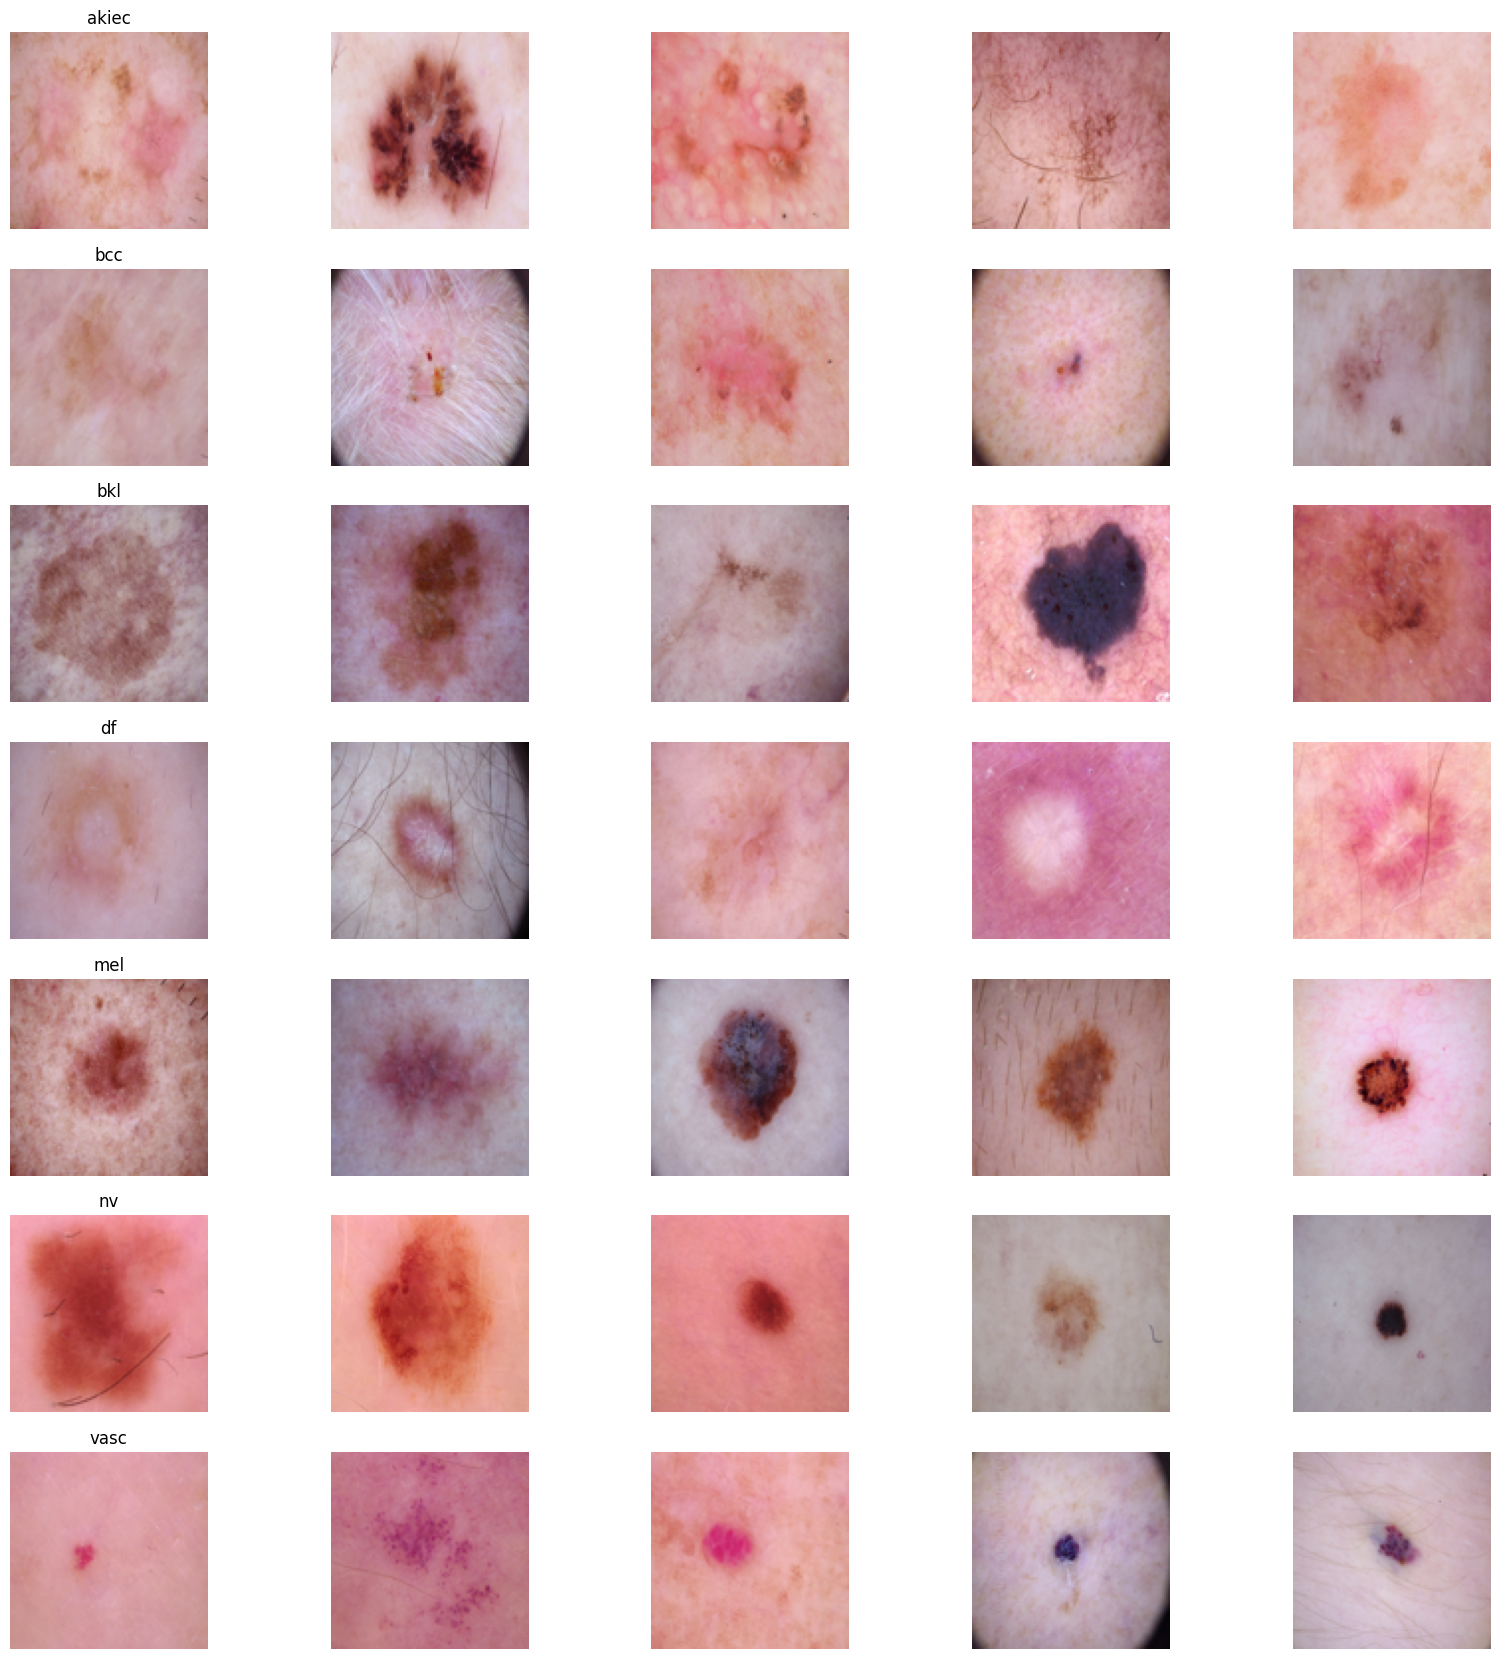

In [94]:

n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')



In [95]:
# Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
# X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
# Y_cat = torch.nn.functional.one_hot(torch.tensor(Y.values), num_classes=7).detach().numpy()
# Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y, test_size=0.95, random_state=42)

#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)


In [96]:
from autoPyTorch import AutoNetClassification

In [97]:
# data and metric imports
import sklearn.model_selection
import sklearn.metrics


In [98]:

# running Auto-PyTorch
autoPyTorch = AutoNetClassification(
    config_preset="tiny_cs",
    networks=["resnet", "shapedresnet", "mlpnet", "shapedmlpnet"],
#     max_runtime=80, 
    min_budget=150, max_budget=200, budget_type='epochs',
    cuda=False, use_pynisher=False
)


In [99]:
model = autoPyTorch.fit(x_train_auto, y_train_auto, X_valid=x_valid, Y_valid=y_valid)


14:52:15 Validation split is set to 0.3 and validation set is specified, autonet will ignore split and evaluate on given validation set
C:\Users\zacba\miniconda3\envs\ap\lib\site-packages\sklearn\preprocessing\_encoders.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
C:\Users\zacba\miniconda3\envs\ap\lib\site-packages\sklearn\preprocessing\_encoders.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify

In [100]:
torch_model = autoPyTorch.get_pytorch_model()

In [101]:
torch_model

Sequential(
  (0): Linear(in_features=99, out_features=193, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.7469011044046886, inplace=False)
  (3): Linear(in_features=193, out_features=23, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5224080843546736, inplace=False)
  (6): Linear(in_features=23, out_features=109, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.6891728517632907, inplace=False)
  (9): Linear(in_features=109, out_features=272, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5478821344929797, inplace=False)
  (12): Linear(in_features=272, out_features=44, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.3319609120711965, inplace=False)
  (15): Linear(in_features=44, out_features=180, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.672298330105537, inplace=False)
  (18): Linear(in_features=180, out_features=84, bias=True)
  (19): ReLU()
  (20): Dropout(p=0.03275362755926379, inplace=False)
  (21): Linear(in_features=84, out_features=51, bias=True)
  (22): ReLU()
  (23): Dropout(p=0.1672139

In [102]:
y_pred = autoPyTorch.predict(x_unused)

In [103]:
y_pred.shape

(18952, 1)

In [104]:
np.unique(y_pred)

array([6.], dtype=float32)

In [105]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_unused, y_pred))

Accuracy score 0.14230688054031237


In [106]:
apnp = np.array(tuple(zip(y_pred[:, 0], y_unused.values)))

In [107]:
apnp[:, 0]

array([6., 6., 6., ..., 6., 6., 6.])

In [108]:
apnp[:, 1]

array([5., 4., 3., ..., 3., 0., 4.])

In [109]:
np.unique(apnp[:, 0] == apnp[:, 1], return_counts=True)

(array([False,  True]), array([16255,  2697], dtype=int64))

In [110]:
np.unique(apnp[:, 0] == apnp[:, 1], return_counts=True)[1] / apnp.shape[0]

array([0.85769312, 0.14230688])

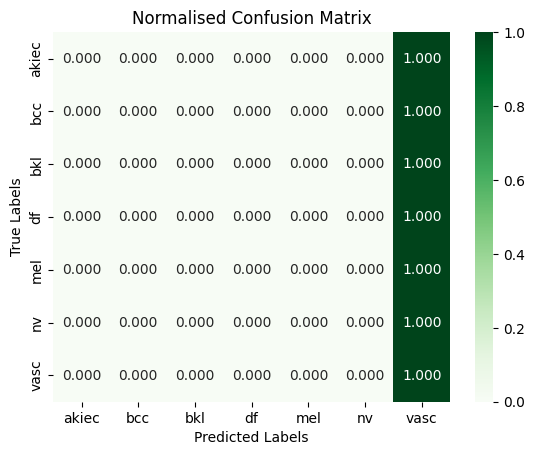

In [111]:
from sklearn.metrics import confusion_matrix
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING) # To get rid of logging error that does not effect code

# y_unused are true labels and y_pred are predicted labels
cm = confusion_matrix(y_unused, y_pred)

# Normalise the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalised confusion matrix
sns.heatmap(cm_normalized, annot=True, cmap='Greens', fmt='.3f', 
            xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], 
            yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalised Confusion Matrix')
plt.show()
